# IMPORTS

In [1]:
import pandas as pd, numpy as np
import sklearn
import scipy.sparse
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

## UNCOMMENT TO PROCESS DATA FROM SCRATCH

In [18]:
data = pd.read_csv('../data/raw_data/blah.csv')
labels=(data["toxic"] | data["severe_toxic"] | data["obscene"] | data["threat"] | data["insult"] | data["identity_hate"])
# labels=data["Labels"]
train_data = data[0:100000]
test_data = data[100001:]
train_labels = labels[0:100000]
test_labels = labels[100001:]

## CLEANING DATA 
# clean_comments = remove_stop_words(data)
# ret = make_feature_vec(clean_comments)

type(data)

pandas.core.frame.DataFrame

In [3]:
corpus = data["comment_text"]
vectorizer = CountVectorizer(strip_accents='unicode',lowercase=True,stop_words='english', analyzer="word",token_pattern=r'\w{1,}')
X = vectorizer.fit_transform(corpus)

vocab = vectorizer.get_feature_names()
train_feature_vectors_sparse = X[0:100000]
test_feature_vectors_sparse = X[100001:]


# USE ALREADY PROCESSED DATA

In [4]:
# labels = pd.read_csv('../data/Processed/labels.csv')["labels"]
# train_labels = labels[0:100000]
# test_labels = labels[100001:]

# train_feature_vectors_sparse_load = scipy.sparse.load_npz('../data/Processed/sparse_train_matrix.npz')

# train_feature_vectors_sparse = train_feature_vectors_sparse_load[0:100000]
# test_feature_vectors_sparse = train_feature_vectors_sparse_load[100001:]
# vocab = pd.read_csv('../data/Processed/vocab.csv')["vocab"]

In [5]:
print("Shape of train vec:", train_feature_vectors_sparse.shape)
print("Shape of test vec:", test_feature_vectors_sparse.shape)

Shape of train vec: (100000, 188744)
Shape of test vec: (59570, 188744)


# TRAINING COMPLEMENT-NB CLASSIFIER

In [49]:
#TRAINING
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
clf = ComplementNB()
clf.fit(train_feature_vectors_sparse, train_labels)

# PREDICTION
predictions = clf.predict(test_feature_vectors_sparse)

print("% of 1s in taining data",sum(test_labels)/len(test_labels))
print("% if 1s in test data", sum(train_labels)/len(train_labels))
print()

# PERFORMANCE METRICS

confmat = confusion_matrix(test_labels, predictions)

precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
fScore = (2*precision*recall)/(recall+precision)
ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

print("Precision = ",precision)
print("Recall = ",recall)
print("F_score = ",fScore)
print("CCR = ",ccr)
print()
print("Confusion Matrix: \n", confmat)

% of 1s in taining data 0.101292596945
% if 1s in test data 0.10191

Precision =  0.694066953928
Recall =  0.596071733561
F_score =  0.64134762634
CCR =  0.921369817022

Confusion Matrix: 
 [[50698  2838]
 [ 1846  4188]]


###### TEST DATA PROCESSING - STRAY BLOCK FOR LATER USAGE

In [6]:
##### STRAY BLOCK FOR LATER USAGE #####

# # creating sparse representation of test feature vectors
# vocab_mapping=set(zip([i for i in range (0,len(vocab))],vocab))
# print("Starting to create bag of words...")
# vectorizer_test = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, vocabulary=vocab_mapping)
# test_feature_vectors_sparse = vectorizer_test.fit_transform(clean_test_comments)
test_feature_vectors_full = test_feature_vectors_sparse.toarray()
train_feature_vectors_full = train_feature_vectors_sparse.toarray()
# print("Bag of words created.")

# USING NORMAL MULTINOMIAL-NB, THE F-SCORE DECREASES

In [51]:
# TRAINING
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_feature_vectors_sparse, train_labels)

# PREDICTION
predictions = clf.predict(test_feature_vectors_sparse)


# PERFORMANCE METRICS

confmat = sklearn.metrics.confusion_matrix(test_labels, predictions)

precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
fScore = (2*precision*recall)/(recall+precision)
ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

print("Precision = ",precision)
print("Recall = ",recall)
print("F_score = ",fScore)
print("CCR = ",ccr)
print()
print("Confusion Matrix: \n", confmat)

Precision =  0.602088167053
Recall =  0.763716628127
F_score =  0.673338893522
CCR =  0.940825919087

Confusion Matrix: 
 [[52412  1124]
 [ 2401  3633]]


# TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True, sublinear_tf=False)
X_train_tfidf = tfidf_transformer.fit_transform(train_feature_vectors_sparse)
X_test_tfidf = tfidf_transformer.transform(test_feature_vectors_sparse)
tfidf_transformer

TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False, use_idf=True)

### Multinomial NB

In [53]:
# TRAINING
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf, train_labels)

# PREDICTION
predictions = clf.predict(X_test_tfidf)


# PERFORMANCE METRICS

confmat = sklearn.metrics.confusion_matrix(test_labels, predictions)

precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
fScore = (2*precision*recall)/(recall+precision)
ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

print("Precision = ",precision)
print("Recall = ",recall)
print("F_score = ",fScore)
print("CCR = ",ccr)
print()
print("Confusion Matrix: \n", confmat)

Precision =  0.803115677826
Recall =  0.442274345167
F_score =  0.570419633924
CCR =  0.87747188182

Confusion Matrix: 
 [[47425  6111]
 [ 1188  4846]]


### Complement NB

In [54]:
# TRAINING
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(X_train_tfidf, train_labels)

# PREDICTION
predictions = clf.predict(X_test_tfidf)


# PERFORMANCE METRICS

confmat = sklearn.metrics.confusion_matrix(test_labels, predictions)

precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
fScore = (2*precision*recall)/(recall+precision)
ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

print("Precision = ",precision)
print("Recall = ",recall)
print("F_score = ",fScore)
print("CCR = ",ccr)
print()
print("Confusion Matrix: \n", confmat)

Precision =  0.812562147829
Recall =  0.425718503082
F_score =  0.558714603157
CCR =  0.869984891724

Confusion Matrix: 
 [[46922  6614]
 [ 1131  4903]]


# GAUSSIAN NAIVE BAYES

In [1]:
# # TRAINING
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

# for i in range(0, 10000):
#     if(i%100 == 0):
        
#         print("Iter", (i/100) + 1, "of", 100)
#     clf.partial_fit(train_feature_vectors_full[10*i:10*(i+1), :], train_labels[10*i:10*(i+1)], classes=np.array([0,1]), sample_weight=None)

# # PREDICTION
# predictions = clf.predict(test_feature_vectors_full)


# # PERFORMANCE METRICS

# confmat = sklearn.metrics.confusion_matrix(test_labels, predictions)

# precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
# recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
# fScore = (2*precision*recall)/(recall+precision)
# ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

# print("Precision = ",precision)
# print("Recall = ",recall)
# print("F_score = ",fScore)
# print("CCR = ",ccr)
# print()
# print("Confusion Matrix: \n", confmat)

# WORD2VEC

In [6]:
analyze = vectorizer.build_analyzer()

sentences = []
for comment in data["comment_text"]:    
    sentences.append(analyze(comment))


In [7]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

from gensim.models import word2vec
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [8]:
word2vec_matrix = model.wv.vectors
word2vec_matrix_sparse = sparse.csr_matrix(word2vec_matrix)

f = np.dot(X,word2vec_matrix_sparse)
train_feature_vectors_full = f[0:100000].toarray()
test_feature_vectors_full = f[100001:].toarray()


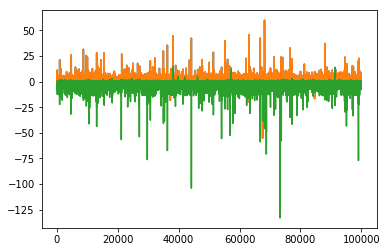

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_feature_vectors_full[:,1])
plt.plot(train_feature_vectors_full[:,200])
plt.show()

In [11]:
# TRAINING
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(train_feature_vectors_full, train_labels)

# PREDICTION
predictions = clf.predict(test_feature_vectors_full)


# PERFORMANCE METRICS

confmat = confusion_matrix(test_labels, predictions)

precision = confmat[1,1]/(confmat[1,1] + confmat[1,0])
recall = confmat[1,1]/(confmat[1,1] + confmat[0,1])
fScore = (2*precision*recall)/(recall+precision)
ccr = (confmat[0,0] + confmat[1,1])/(sum(sum(confmat)))

print("Precision = ",precision)
print("Recall = ",recall)
print("F_score = ",fScore)
print("CCR = ",ccr)
print()
print("Confusion Matrix: \n", confmat)

Precision =  0.038283062645
Recall =  0.0609498680739
F_score =  0.0470276872964
CCR =  0.842840355884

Confusion Matrix: 
 [[49977  3559]
 [ 5803   231]]
